In [150]:
import os
import pandas as pd
import json
import numpy as np
import seaborn as sns

from sklearn import metrics
from functools import reduce
import scipy as sp
from scipy import cluster as scl
from scipy import stats, integrate
from matplotlib import pyplot as plt
from matplotlib import gridspec as gs
import matplotlib as mpl

%matplotlib inline
sns.set(style="white")

In [151]:
def CustomParser(data):
    j1 = json.loads(data)
    return j1

In [152]:
# set path
#path_root = '/media/yassinebha/database29/Drive/QC_zooniverse_2'
path_root = '/home/yassinebha/data/data_disk/Drive/QC_zooniverse_2'
#path_root = '/media/yassine/data_disk/Drive/QC_zooniverse_2'

In [170]:
# Read raw table and convert json to dictionary
classifications = pd.read_csv(os.path.join(path_root,'full_lunch_anat_V01/start-project-1-classifications_final.csv'), converters={'metadata':CustomParser,'annotations':CustomParser,'subject_data':CustomParser},header=0)

classifications.head()

,classification_id,user_name,user_id,user_ip,workflow_id,workflow_name,workflow_version,created_at,gold_standard,expert,metadata,annotations,subject_data,subject_ids
0,71986518,mrniaboc,107.0,48e40b5ef0f87a901437,5047,Start Project 1,1.1,2017-09-27 13:28:15 UTC,NaN,NaN,"{'live_project': True, 'user_language': 'en', ...","[{'task': 'T1', 'task_label': 'Tag mismatched ...","{'13250031': {'image1': 'X_0023027_anat.png', ...",13250031
1,71986630,mrniaboc,107.0,48e40b5ef0f87a901437,5047,Start Project 1,1.1,2017-09-27 13:28:55 UTC,NaN,NaN,"{'live_project': True, 'user_language': 'en', ...","[{'task': 'T1', 'task_label': 'Tag mismatched ...","{'13250023': {'image1': 'X_2054998_anat.png', ...",13250023
2,71986899,mrniaboc,107.0,48e40b5ef0f87a901437,5047,Start Project 1,1.1,2017-09-27 13:30:52 UTC,NaN,NaN,"{'live_project': True, 'user_language': 'en', ...","[{'task': 'T1', 'task_label': 'Tag mismatched ...","{'13250006': {'image1': 'X_3848511_anat.png', ...",13250006
3,71986947,mrniaboc,107.0,48e40b5ef0f87a901437,5047,Start Project 1,1.1,2017-09-27 13:31:12 UTC,NaN,NaN,"{'live_project': True, 'user_language': 'en', ...","[{'task': 'T1', 'task_label': 'Tag mismatched ...","{'13250035': {'image1': 'X_0010032_anat.png', ...",13250035
4,71986979,mrniaboc,107.0,48e40b5ef0f87a901437,5047,Start Project 1,1.1,2017-09-27 13:31:23 UTC,NaN,NaN,"{'live_project': True, 'user_language': 'en', ...","[{'task': 'T1', 'task_label': 'Tag mismatched ...","{'13250043': {'image1': 'X_3679455_anat.png', ...",13250043


In [171]:
len(classifications.user_id.unique())

245

In [172]:
classifications.count()

classification_id    4280
user_name            4280
user_id              3652
user_ip              4280
workflow_id          4280
workflow_name        4280
workflow_version     4280
created_at           4280
gold_standard           0
expert                  0
metadata             4280
annotations          4280
subject_data         4280
subject_ids          4280
dtype: int64

In [173]:
# Save jenny and cole rating for later use
# Read raw table without parsing json
classifi = pd.read_csv(os.path.join(path_root,'full_lunch_anat_V01/start-project-1-classifications_final.csv'),
                       header=0)
# Select users and save
df_jeni_cole= classifi[classifi.user_name.isin(['colezweber','ppf'])]
df_jeni_cole.to_csv(os.path.join(path_root,'full_lunch_anat_V01/jeni_cole-classifications_raw.csv'),index=False, 
                    encoding='utf-8')

In [174]:
# remove not logged in raters
classifications = classifications[classifications.user_name.str.find("not-logged-in")==-1]
len(classifications.user_id.unique())

244

In [175]:
# extract tagging count
classifications.loc[:,"n_tagging"] = [ len(q[0]['value']) for q in classifications.annotations]
# extract rating count
classifications.loc[:,"rating"] = [ q[1]['value'] for q in classifications.annotations]
# extract subjects id
classifications.loc[:,"ID"] = [ row.subject_data[str(classifications.subject_ids[ind])]['subject_ID'] for ind,row in classifications.iterrows()]
# extract files name
classifications.loc[:,"imgnm"] = [ row.subject_data[str(classifications.subject_ids[ind])]['image1'] for ind,row in classifications.iterrows()]

In [176]:
classifications.head()

,classification_id,user_name,user_id,user_ip,workflow_id,workflow_name,workflow_version,created_at,gold_standard,expert,metadata,annotations,subject_data,subject_ids,n_tagging,rating,ID,imgnm
0,71986518,mrniaboc,107.0,48e40b5ef0f87a901437,5047,Start Project 1,1.1,2017-09-27 13:28:15 UTC,NaN,NaN,"{'live_project': True, 'user_language': 'en', ...","[{'task': 'T1', 'task_label': 'Tag mismatched ...","{'13250031': {'image1': 'X_0023027_anat.png', ...",13250031,0,Fail,X0023027,X_0023027_anat.png
1,71986630,mrniaboc,107.0,48e40b5ef0f87a901437,5047,Start Project 1,1.1,2017-09-27 13:28:55 UTC,NaN,NaN,"{'live_project': True, 'user_language': 'en', ...","[{'task': 'T1', 'task_label': 'Tag mismatched ...","{'13250023': {'image1': 'X_2054998_anat.png', ...",13250023,0,Fail,X2054998,X_2054998_anat.png
2,71986899,mrniaboc,107.0,48e40b5ef0f87a901437,5047,Start Project 1,1.1,2017-09-27 13:30:52 UTC,NaN,NaN,"{'live_project': True, 'user_language': 'en', ...","[{'task': 'T1', 'task_label': 'Tag mismatched ...","{'13250006': {'image1': 'X_3848511_anat.png', ...",13250006,0,Fail,X3848511,X_3848511_anat.png
3,71986947,mrniaboc,107.0,48e40b5ef0f87a901437,5047,Start Project 1,1.1,2017-09-27 13:31:12 UTC,NaN,NaN,"{'live_project': True, 'user_language': 'en', ...","[{'task': 'T1', 'task_label': 'Tag mismatched ...","{'13250035': {'image1': 'X_0010032_anat.png', ...",13250035,0,Fail,X0010032,X_0010032_anat.png
4,71986979,mrniaboc,107.0,48e40b5ef0f87a901437,5047,Start Project 1,1.1,2017-09-27 13:31:23 UTC,NaN,NaN,"{'live_project': True, 'user_language': 'en', ...","[{'task': 'T1', 'task_label': 'Tag mismatched ...","{'13250043': {'image1': 'X_3679455_anat.png', ...",13250043,0,Fail,X3679455,X_3679455_anat.png


In [177]:
# Drop unwanted rater( here 3 expert and one outlayer )
classifications = classifications[~classifications.user_name.isin(['jenichen','colezweber','ppf','willy71'])]

In [178]:
len(classifications.user_id.unique())

240

In [179]:
classifications.count()

classification_id    3172
user_name            3172
user_id              3172
user_ip              3172
workflow_id          3172
workflow_name        3172
workflow_version     3172
created_at           3172
gold_standard           0
expert                  0
metadata             3172
annotations          3172
subject_data         3172
subject_ids          3172
n_tagging            3172
rating               3172
ID                   3172
imgnm                3172
dtype: int64

In [180]:
# How many rating per user
user_count = classifications.user_name.value_counts()
user_count

MsImmortal          126
lobusparietalis     105
alinanaseer         103
1010101             103
sueburr             102
RLINDS4026          100
Uganalandia         100
rubyadeline         100
hallkr               99
narguedasn           95
ashherr17            92
juliejo              87
kitchenmi            69
AlyPereira21         67
ChaoticK             54
Michaelspili         54
alyssalewis4         50
Dillen               49
1a2r3u4n             45
AndrejGalinac        44
Hmelting             41
sanitha.yang         39
Service55            39
BuckHunter           37
kyla_aamodt          35
healyodonnell        32
PeterZXY             32
naomishriner         30
adamsmadison1        29
cbernardo            29
                   ... 
blicksam              1
sinjinza1984          1
Camda5585             1
GuyNelson             1
HannahO1              1
Tirao24               1
aleksandra655321      1
aricar                1
sabrinahiew           1
MAMAMIMI              1
cassie.bradshaw 

In [181]:
# drop duplicated rating
inc = 0
sum_dup = 0
for ind,user in enumerate(classifications.user_name.unique()):
    user_select_df = classifications[classifications.user_name.isin([user])]
    mask=~user_select_df.ID.duplicated()
    dup = len([m for m in mask if m == False])
    sum_dup = sum_dup+ dup
    if dup > 0 :
        print('{} have {} duplicated ratings'.format(user,dup))
    if ind == 0 and inc == 0:
        classi_unique= user_select_df[mask]
        inc+=1
    else:
        classi_unique = classi_unique.append(user_select_df[~user_select_df.ID.duplicated()])
        inc+=1
print('Total number of duplicated ratings  = {}'.format(sum_dup))

hallkr have 1 duplicated ratings
1a2r3u4n have 2 duplicated ratings
MsImmortal have 26 duplicated ratings
lobusparietalis have 5 duplicated ratings
Dillen have 1 duplicated ratings
ritu99 have 1 duplicated ratings
1010101 have 3 duplicated ratings
kitchenmi have 1 duplicated ratings
sueburr have 2 duplicated ratings
ashherr17 have 16 duplicated ratings
alinanaseer have 39 duplicated ratings
AlyPereira21 have 23 duplicated ratings
alyssalewis4 have 1 duplicated ratings
PeterZXY have 3 duplicated ratings
adamsmadison1 have 2 duplicated ratings
Maya_Cudjoe have 2 duplicated ratings
Neferpitou have 1 duplicated ratings
Total number of duplicated ratings  = 129


In [182]:
classi_unique.count()

classification_id    3043
user_name            3043
user_id              3043
user_ip              3043
workflow_id          3043
workflow_name        3043
workflow_version     3043
created_at           3043
gold_standard           0
expert                  0
metadata             3043
annotations          3043
subject_data         3043
subject_ids          3043
n_tagging            3043
rating               3043
ID                   3043
imgnm                3043
dtype: int64

Text(0,0.5,'Number of images')

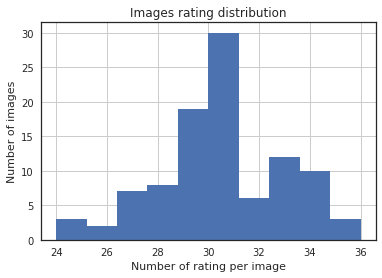

In [183]:
# Visualize images rating distribution

# subselect images 
df_ids = classi_unique.groupby(['ID']).size().reset_index(name='Count')

# sort them
df_sorted= df_ids.sort_values('Count')

# plot soted histograme
fig, axes = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True)
df_ids.hist(ax = axes)
axes.set_title('Images rating distribution')
axes.xaxis.set_label_text('Number of rating per image')
axes.yaxis.set_label_text('Number of images')

In [35]:
# # remove not logged in raters
# classi_unique = classi_unique[classi_unique.user_name.str.find("not-logged-in")==-1]
# classi_unique.count()

In [187]:
#select only users that have rated a certain ammount of images 
user_count = classi_unique.user_name.value_counts()
list_user = user_count.index
list_user = list_user[user_count.values>15]
user_count[list_user]

lobusparietalis    100
RLINDS4026         100
MsImmortal         100
rubyadeline        100
sueburr            100
1010101            100
Uganalandia        100
hallkr              98
narguedasn          95
juliejo             87
ashherr17           76
kitchenmi           68
alinanaseer         64
Michaelspili        54
ChaoticK            54
alyssalewis4        49
Dillen              48
AndrejGalinac       44
AlyPereira21        44
1a2r3u4n            43
Hmelting            41
sanitha.yang        39
Service55           39
BuckHunter          37
kyla_aamodt         35
healyodonnell       32
naomishriner        30
cbernardo           29
PeterZXY            29
ryansadjadi         28
adamsmadison1       27
pfritze             27
LeonLiu             24
FemkeLara           23
Jardy57             22
enehta              21
Inannani            19
ritu99              19
dreinks             19
jimin9435           18
bunnigirl           17
amanina             17
missscarletwolf     16
silentbuteo

In [188]:
# remove users with less rating then the selected threshold
classi_unique = classi_unique[classi_unique.user_name.isin(list_user)]
classi_unique.count()

classification_id    2148
user_name            2148
user_id              2148
user_ip              2148
workflow_id          2148
workflow_name        2148
workflow_version     2148
created_at           2148
gold_standard           0
expert                  0
metadata             2148
annotations          2148
subject_data         2148
subject_ids          2148
n_tagging            2148
rating               2148
ID                   2148
imgnm                2148
dtype: int64

In [189]:
len(classi_unique.user_id.unique())

44

In [190]:
classifications.to_csv(os.path.join(path_root,'full_lunch_anat_V01/non_expert-project-classifications_raw.csv'))

In [191]:
#Merge Users rating
concat_rating = [classi_unique[classi_unique.user_name == user][['ID','rating']].rename(columns={'rating': user})
                  for user in list_user]
# keep unique ID's
#concats_unique = [conctat_rating[ii].ix[conctat_rating[ii].ix[:,0] ] 
#                  for ii in range(len(conctat_rating))]
df_rating = reduce(lambda left,right: pd.merge(left,right,how='outer',on='ID'), concat_rating)

In [192]:
df_rating.count()

ID                 100
lobusparietalis    100
RLINDS4026         100
MsImmortal         100
rubyadeline        100
sueburr            100
1010101            100
Uganalandia        100
hallkr              98
narguedasn          95
juliejo             87
ashherr17           76
kitchenmi           68
alinanaseer         64
Michaelspili        54
ChaoticK            54
alyssalewis4        49
Dillen              48
AndrejGalinac       44
AlyPereira21        44
1a2r3u4n            43
Hmelting            41
sanitha.yang        39
Service55           39
BuckHunter          37
kyla_aamodt         35
healyodonnell       32
naomishriner        30
cbernardo           29
PeterZXY            29
ryansadjadi         28
adamsmadison1       27
pfritze             27
LeonLiu             24
FemkeLara           23
Jardy57             22
enehta              21
Inannani            19
ritu99              19
dreinks             19
jimin9435           18
bunnigirl           17
amanina             17
missscarlet

In [193]:
# remove duplicates
#df_rating = df_rating[~df_rating.ID.duplicated()]

In [194]:
stuff = np.array([[row.ID,
                   np.sum(row[1:-1].values=='Fail'),
                   np.sum(row[1:-1].values=='Maybe'),
                   np.sum(row[1:-1].values=='OK')] for ind, row in df_rating.iterrows()])

In [195]:
df_score = pd.DataFrame(index=df_rating.index,data=stuff, columns=['ID','Fail', 'Maybe', 'OK'])

In [196]:
# Normalise table's row
df_score_tmp = df_score[['Fail','Maybe','OK']].astype('int')
nb_rating = df_score[['Fail','Maybe','OK']].astype('int').sum(axis="columns")
df_norm = pd.DataFrame( index=df_rating.index,columns=['ID','Fail', 'Maybe', 'OK'])
for status in ['Fail','Maybe','OK']:
    for image in df_score.index:
        df_norm[status][image] = np.int(df_score[status][image])/nb_rating[image]
        df_norm['ID'][image] = df_score['ID'][image]
# get max value
max_value = [row.iloc[1:].get_values().max() for ind,row in df_norm.iterrows()]
df_norm.loc[:,'max_value_NoExp'] = max_value
# get concensus rating
s = ['Fail', 'Maybe', 'OK']
#max_rate = [row.iloc[1:].idxmax(axis=1) for ind,row in df_norm.iterrows()]
max_rate = [s[row[1:].values.argmax()] for rid, row in df_norm.iterrows()]
df_norm.loc[:,'concensus_NoExp'] = max_rate

In [197]:
df_norm.head()

,ID,Fail,Maybe,OK,max_value_NoExp,concensus_NoExp
0,X1743472,0.576923,0.269231,0.153846,0.576923,Fail
1,X3662296,0.36,0.44,0.2,0.440000,Maybe
2,X2443191,0.0526316,0.157895,0.789474,0.789474,OK
3,HC0040055,0.08,0.2,0.72,0.720000,OK
4,X4104523,0.368421,0.421053,0.210526,0.421053,Maybe


In [198]:
df_norm.to_csv(os.path.join(path_root,'full_lunch_anat_V01/non_expert_rating.csv'),index=False)

In [199]:
df_norm.loc[df_norm['max_value_NoExp']  <= 0.5]

,ID,Fail,Maybe,OK,max_value_NoExp,concensus_NoExp
1,X3662296,0.36,0.44,0.2,0.440000,Maybe
4,X4104523,0.368421,0.421053,0.210526,0.421053,Maybe
11,X0021015,0.190476,0.428571,0.380952,0.428571,Maybe
18,X0010045,0.5,0.05,0.45,0.500000,Fail
20,X1038415,0.227273,0.454545,0.318182,0.454545,Maybe
22,X0010009,0.142857,0.380952,0.47619,0.476190,OK
27,HC0040045,0.0909091,0.409091,0.5,0.500000,OK
28,X0021018,0.35,0.2,0.45,0.450000,OK
29,X2920716,0.428571,0.285714,0.285714,0.428571,Fail
38,X0010038,0.230769,0.307692,0.461538,0.461538,OK


In [200]:
def sample_dataframe(df,perc,seed=0):
    ''' 
    Randomly select a subset of dataframe
    input
        df:  a adtaframe object 
        perc: percentage of date to be subseted<
    output
        df_subSamp: subsetted dataframe
        msk: boolean mask of subsetted value
    '''
    np.random.seed(seed)
    msk = np.random.rand(len(df)) < perc
    df_subSamp = df[msk]
    return df_subSamp,msk

In [201]:
def select_users(df,thresh):
    '''
    select only users that have rated a certain ammount of images
    '''
    user_count = df.user_name.value_counts()
    list_user = user_count.index
    list_user = list_user[user_count.values>thresh]
    return list_user
    

In [202]:
def merge_users_rating(df,list_user):
    #Merge Users rating
    concat_rating = [df[df.user_name == user][['ID','rating']].rename(columns={'rating': user})
                      for user in list_user]
    df_rating = reduce(lambda left,right: pd.merge(left,right,how='outer',on='ID'), concat_rating)
    # make new dataframe out of merged ratings
    stuff = np.array([[row.ID,
                   np.sum(row[1:-1].values=='Fail'),
                   np.sum(row[1:-1].values=='Maybe'),
                   np.sum(row[1:-1].values=='OK')] for ind, row in df_rating.iterrows()])
    df_score = pd.DataFrame(index=df_rating.index,data=stuff, columns=['ID','Fail', 'Maybe', 'OK'])
    return df_score,df_rating

In [203]:
def normalize_rating(df_score,df_rating):
    # Normalise table's row
    df_score_tmp = df_score[['Fail','Maybe','OK']].astype('int')
    nb_rating = df_score[['Fail','Maybe','OK']].astype('int').sum(axis="columns")
    df_norm = pd.DataFrame( index=df_rating.index,columns=['ID','Fail', 'Maybe', 'OK'])
    for status in ['Fail','Maybe','OK']:
        for image in df_score.index:
            df_norm[status][image] = np.int(df_score[status][image])/nb_rating[image]
            df_norm['ID'][image] = df_score['ID'][image]
    # get max value
    max_value = [row.iloc[1:].get_values().max() for ind,row in df_norm.iterrows()]
    df_norm.loc[:,'max_value_NoExp_t'] = max_value
    # get concensus rating
    max_rate = [row.iloc[1:].idxmax(axis=1) for ind,row in df_norm.iterrows()]
    df_norm.loc[:,'concensus_NoExp_t'] = max_rate
    return(df_norm)

In [204]:
def visu_rating_img_dist(df,title):
    # Visualize images rating distribution
    # subselect images 
    df_ids = df.groupby(['ID']).size().reset_index(name='Count')
    # sort them
    df_sorted= df_ids.sort_values('Count')
    # plot soted histograme
    fig, axes = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True)
    df_ids.hist(ax = axes)
    axes.set_title(title)
    axes.xaxis.set_label_text('Number of rating per image')
    axes.yaxis.set_label_text('Number of images')

In [65]:
#split half kappa estimate
df_subSamp_1,msk = sample_dataframe(classi_unique,0.5,134)
df_subSamp_2=classi_unique[~msk]
list_user_1 = select_users(df_subSamp_1,0)
list_user_2 =  select_users(df_subSamp_2,0)
df_merge_rater_1,df_subRater_1 = merge_users_rating(df_subSamp_1,list_user_1)
df_merge_rater_2,df_subRater_2 = merge_users_rating(df_subSamp_2,list_user_2)
df_merge_rater_norm_1 = normalize_rating(df_merge_rater_1,df_subRater_1)
df_merge_rater_norm_2 = normalize_rating(df_merge_rater_2,df_subRater_2)

# generate concensus table
df_kappa_tmp =df_merge_rater_norm_1[['ID','concensus_NoExp_t']].merge(df_merge_rater_norm_2[['ID','concensus_NoExp_t']],
                                                                    how='left',
                                                                    on='ID')
df_kappa_tmp.replace({'OK':1,'Maybe':2, 'Fail':3}, inplace=True)
df_kappa_tmp.dropna(inplace=True)

In [66]:
rater1 = df_kappa_tmp['concensus_NoExp_t_x']

In [67]:
rater2 = df_kappa_tmp['concensus_NoExp_t_y']

In [68]:
metrics.cohen_kappa_score(rater1,rater2)

0.52911630827185685

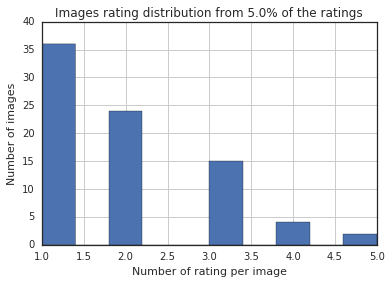

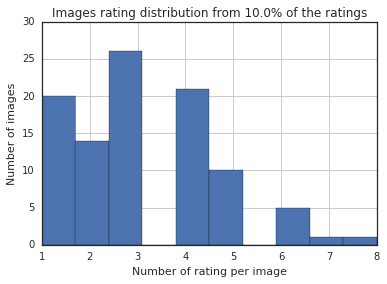

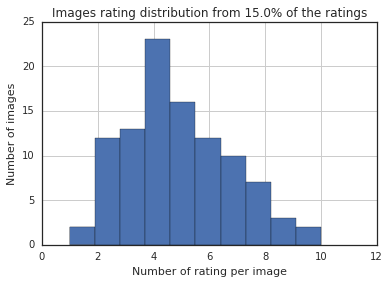

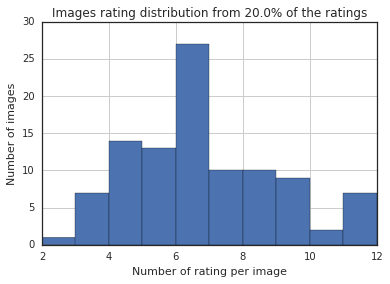

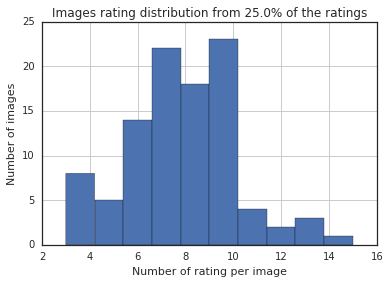

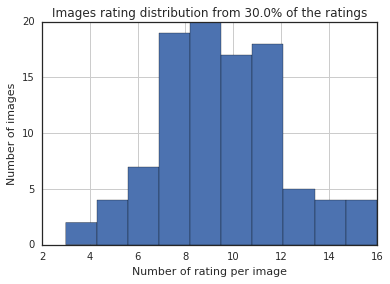

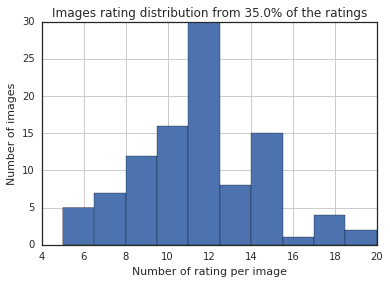

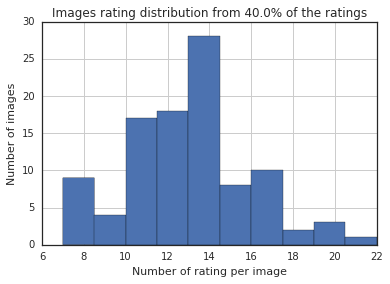

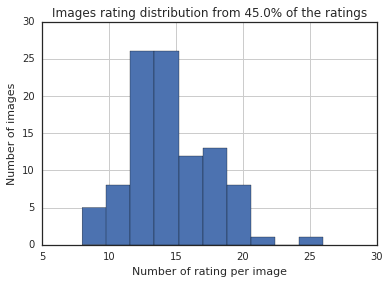

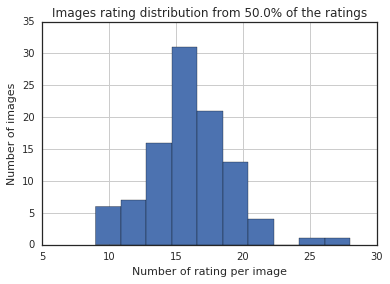

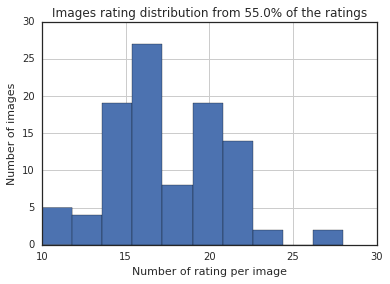

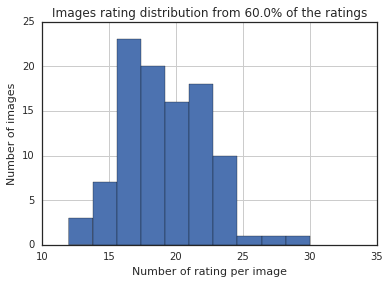

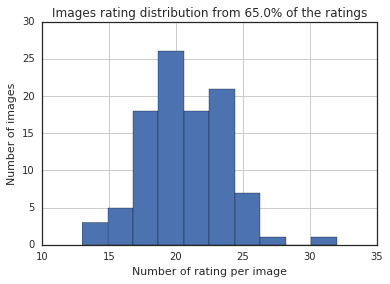

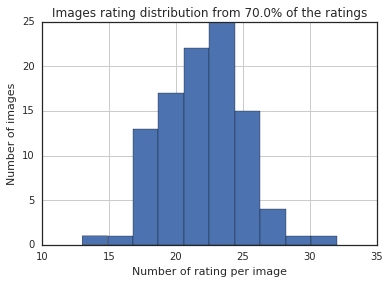

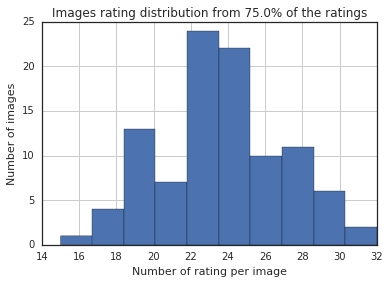

In [69]:

sample_range = np.arange(0.05,0.8,0.05)
kappa_array = np.zeros((len(sample_range), 1))
for ind, val in enumerate(sample_range):
    # subset dataframe
    df_subSamp,msk = sample_dataframe(classi_unique,val)
    visu_rating_img_dist(df_subSamp,'Images rating distribution from {:.1f}% of the ratings'.format(val*100))
    list_user_t = select_users(df_subSamp,0)
    df_merge_rater,df_subRater = merge_users_rating(df_subSamp,list_user_t)
    df_merge_rater_norm = normalize_rating(df_merge_rater,df_subRater)
    
    # generate concensus table
    df_kappa_tmp =df_merge_rater_norm[['ID','concensus_NoExp_t']].merge(df_norm[['ID','concensus_NoExp']],
                                                                    how='left',
                                                                    on='ID')
    df_kappa_tmp.replace({'OK':1,'Maybe':2, 'Fail':3}, inplace=True)
    df_kappa_tmp.dropna(inplace=True)
    
    # Generate Kappa erray
    rater_1 = df_kappa_tmp['concensus_NoExp']
    rater_2 = df_kappa_tmp['concensus_NoExp_t']
    kappa = metrics.cohen_kappa_score(rater_1,rater_2)
    kappa_array[ind] = kappa
    

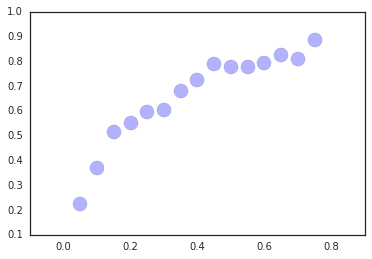

In [77]:
plt.scatter(sample_range,kappa_array,alpha=0.3,s=200)

In [188]:
df_subSamp,msk = sample_dataframe(classi_unique,0.5)

In [189]:
df_subSamp.count()

classification_id    1615
user_name            1615
user_id              1427
user_ip              1615
workflow_id          1615
workflow_name        1615
workflow_version     1615
created_at           1615
gold_standard           0
expert                  0
metadata             1615
annotations          1615
subject_data         1615
subject_ids          1615
n_tagging            1615
rating               1615
ID                   1615
imgnm                1615
dtype: int64

#### Histograms
Histograms of the frequency of the "OK", "Maybe" and "fail" rating across raters, for all images. If all raters agreed, we would only have 0% or 100% rating frequencies. 

Text(0.5,1,'OK')

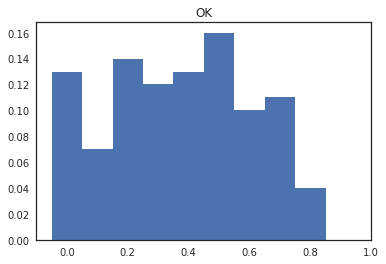

In [205]:
#### Histogram of OK
hok , bins = np.histogram(df_norm.OK,bins=np.arange(0,1.1,0.1))
hok = hok.astype(np.float32) / hok.sum()
plt.bar(bins[:-1], hok , width=(bins[1]-bins[0]))
plt.title('OK')

Text(0.5,1,'Maybe')

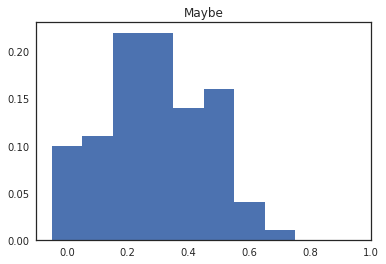

In [206]:
# Histogram of Maybe
hmaybe , bins = np.histogram(df_norm.Maybe,bins=np.arange(0,1.1,0.1))
hmaybe = hmaybe.astype(np.float32) / hmaybe.sum()
plt.bar(bins[:-1], hmaybe , width=(bins[1]-bins[0]))
plt.title('Maybe')

Text(0.5,1,'Fail')

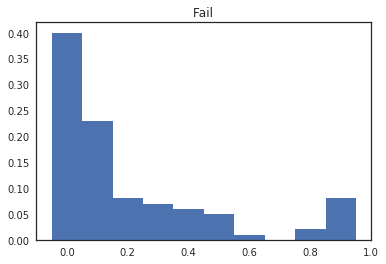

In [207]:
# Histogram of Fail
hfail , bins = np.histogram(df_norm.Fail,bins=np.arange(0,1.1,0.1))
hfail = hfail.astype(np.float32) / hfail.sum()
plt.bar(bins[:-1], hfail , width=(bins[1]-bins[0]))
plt.title('Fail')

## Kappa score

In [215]:
# filter user who completed rating for kappa
name_users_kappa = [ix for ix,x in user_count.iteritems() if x >= 100]


In [216]:
#select raters
df_kappa = df_rating[["ID"]+ name_users_kappa]
df_kappa.count()

ID                 100
lobusparietalis    100
RLINDS4026         100
MsImmortal         100
rubyadeline        100
sueburr            100
1010101            100
Uganalandia        100
dtype: int64

In [217]:
# add matching column 
df_kappa.loc[:,"rating_match"] = df_kappa.iloc[:,1:].apply(lambda x: len(set(x)) == 1, axis=1)

/home/yassinebha/jupyter_py3.0/lib/python3.5/site-packages/pandas/core/indexing.py:357: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/home/yassinebha/jupyter_py3.0/lib/python3.5/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [218]:
df_kappa.head()

,ID,lobusparietalis,RLINDS4026,MsImmortal,rubyadeline,sueburr,1010101,Uganalandia,rating_match
0,X1743472,Maybe,Maybe,Fail,Fail,Maybe,Maybe,Fail,False
1,X3662296,Maybe,Fail,Fail,OK,Maybe,OK,Maybe,False
2,X2443191,OK,Maybe,OK,OK,Fail,OK,OK,False
3,HC0040055,OK,OK,OK,OK,Maybe,OK,OK,False
4,X4104523,Maybe,Fail,Fail,OK,Maybe,Fail,Fail,False


In [219]:
# Add concensus rating
df_kappa=df_kappa.merge(df_norm[['ID','concensus_NoExp']],how='left',on='ID')
# add concensus rating in the user list
name_users_kappa.append('concensus_NoExp')

In [220]:
df_kappa.dropna(inplace=True)

In [221]:
df_kappa.count()

ID                 100
lobusparietalis    100
RLINDS4026         100
MsImmortal         100
rubyadeline        100
sueburr            100
1010101            100
Uganalandia        100
rating_match       100
concensus_NoExp    100
dtype: int64

In [222]:
# Replace OK:1 , Maybe:2 and Fail:3
df_kappa.replace({'OK':1,'Maybe':2, 'Fail':3}, inplace=True)
df_kappa.head()

,ID,lobusparietalis,RLINDS4026,MsImmortal,rubyadeline,sueburr,1010101,Uganalandia,rating_match,concensus_NoExp
0,X1743472,2,2,3,3,2,2,3,False,3
1,X3662296,2,3,3,1,2,1,2,False,2
2,X2443191,1,2,1,1,3,1,1,False,1
3,HC0040055,1,1,1,1,2,1,1,False,1
4,X4104523,2,3,3,1,2,3,3,False,2


In [223]:
# remove duplicates ID's
df_kappa = df_kappa[~df_kappa.ID.duplicated()]# remove duplicates ID's
df_kappa = df_kappa[~df_kappa.ID.duplicated()]
df_kappa.count()

ID                 100
lobusparietalis    100
RLINDS4026         100
MsImmortal         100
rubyadeline        100
sueburr            100
1010101            100
Uganalandia        100
rating_match       100
concensus_NoExp    100
dtype: int64

In [224]:
# calculate the percentage of agreement
agreem_num = (df_kappa.rating_match.sum()/df_kappa.ID.count())*100
"The percentage of agreement is: {:.2f}".format(agreem_num)

'The percentage of agreement is: 12.00'

In [225]:
# Generate Kappa matrix rater by rater
kappa_store = np.zeros((len(name_users_kappa), len(name_users_kappa)))
for net_id in range(len(name_users_kappa)):
    rater_1 = name_users_kappa[net_id]
    for s_id in range(len(name_users_kappa)):
        rater_2 = name_users_kappa[s_id]
        kappa = metrics.cohen_kappa_score(df_kappa[[rater_1]],df_kappa[[rater_2]])
        # Save the kappa
        kappa_store[net_id, s_id] = kappa

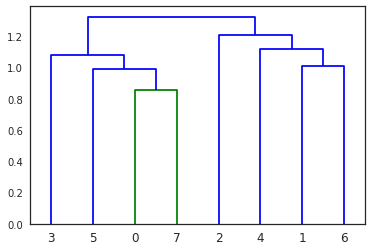

In [226]:
# cluster and order kappa matrix
dist = sp.spatial.distance.pdist(kappa_store)
link = scl.hierarchy.linkage(dist, method='ward')
order = scl.hierarchy.dendrogram(link, no_plot=False)['leaves']
part = scl.hierarchy.fcluster(link, 3, criterion='maxclust')

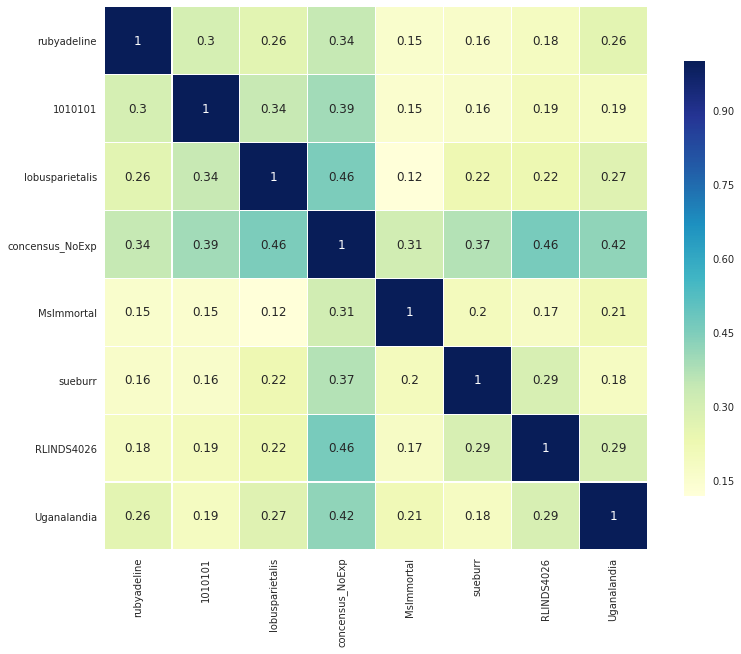

In [227]:
# Plot kappa matrix
kappa_out = pd.DataFrame(kappa_store[order, :][:, order], 
                         index=[name_users_kappa[ord] for ord in order],
                         columns=[name_users_kappa[ord] for ord in order])
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(13, 10))
# Draw the map
sns.heatmap(kappa_out,vmax=1,cmap="YlGnBu",
            square=True,annot=True,
            linewidths=.5, cbar_kws={"shrink": .8}, ax=ax)

In [228]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://i.stack.imgur.com/kYNd6.png" ,width=600, height=600)

## Plot tagging on images 

In [229]:
%matplotlib inline
import os
import matplotlib
import matplotlib.pyplot as plt

In [230]:
#base_path = '/home/yassinebha/Drive/QC_zooniverse_2/brainhack2017/rating_images'

In [231]:
# output markings from 50 classifications
#Basile
clist=[]
for index, c in classifications.iterrows():
    if c['n_tagging'] > 0:
        for q in c.annotations[0]['value']:
            clist.append({'ID':c.ID, 'workflow_name':c.workflow_name,'user_name':c.user_name, 'rating':c.rating,'imgnm':c.imgnm, 
                          'x':q['x'], 'y':np.round(q['y']).astype(int), 'r':'2','n_tagging':c.n_tagging ,'frame':q['frame']})
    else:
        clist.append({'ID':c.ID, 'workflow_name':c.workflow_name, 'user_name':c.user_name,'rating':c.rating,'imgnm':c.imgnm, 
                          'x':float('nan'), 'y':float('nan'), 'r':float('nan'),'n_tagging':c.n_tagging ,'frame':'1'})

col_order=['ID','workflow_name','user_name','rating','x','y','r','n_tagging','imgnm','frame']
out = pd.DataFrame(clist)[col_order]

In [232]:
out.head()

,ID,workflow_name,user_name,rating,x,y,r,n_tagging,imgnm,frame
0,X0023027,Start Project 1,mrniaboc,Fail,NaN,NaN,NaN,0,X_0023027_anat.png,1
1,X2054998,Start Project 1,mrniaboc,Fail,NaN,NaN,NaN,0,X_2054998_anat.png,1
2,X3848511,Start Project 1,mrniaboc,Fail,NaN,NaN,NaN,0,X_3848511_anat.png,1
3,X0010032,Start Project 1,mrniaboc,Fail,NaN,NaN,NaN,0,X_0010032_anat.png,1
4,X3679455,Start Project 1,mrniaboc,Fail,NaN,NaN,NaN,0,X_3679455_anat.png,1


In [233]:
# out only selected rater
out_kappa = out.loc[out['user_name'].isin(name_users_kappa)]
# out only kappa rated images
out_kappa = out_kappa.loc[out_kappa['ID'].isin(df_kappa.ID)]
out_kappa.head()

,ID,workflow_name,user_name,rating,x,y,r,n_tagging,imgnm,frame
35,X3912996,Start Project 1,rubyadeline,Maybe,285.96875,199.0,2,2,X_3912996_anat.png,0
36,X3912996,Start Project 1,rubyadeline,Maybe,313.96875,556.0,2,2,X_3912996_anat.png,0
37,X0023019,Start Project 1,rubyadeline,OK,NaN,NaN,NaN,0,X_0023019_anat.png,1
38,X0021014,Start Project 1,rubyadeline,Fail,69.96875,75.0,2,51,X_0021014_anat.png,0
39,X0021014,Start Project 1,rubyadeline,Fail,103.96875,62.0,2,51,X_0021014_anat.png,0


In [234]:
ids_imgnm = np.reshape([out.ID.unique(),out.imgnm.unique()],(2,np.shape(out.ID.unique())[0]))

In [235]:
from shutil import copyfile, copy2
#base_path_src = os.path.join(path_root,'zooqc_report_adhd_03-Jul-2017/registration')
base_path_src = os.path.join(path_root,'zooqc_report_cobre_03-Jul-2017/registration')
base_path_dest = os.path.join(path_root,'Beta2/rating_images')

In [236]:
# juste run once to collect images in specific folder
#from shutil import copyfile, copy2
#base_path_src = os.path.join(path_root,'zooqc_report_adhd_03-Jul-2017/registration')
#base_path_src = os.path.join(path_root,'zooqc_report_cobre_03-Jul-2017/registration')
#base_path_dest = os.path.join(path_root,'Beta2/rating_images')
#for ii in np.sort(ids_imgnm.T[:,1])[:15]:#[15:]
    #print(ii)
    #copy2(os.path.join(base_path_src,ii),base_path_dest)

In [237]:
df_ids_imgnm = pd.DataFrame(np.sort(ids_imgnm.T, axis=0),columns=['ID', 'imgnm'])

In [238]:
df_ids_imgnm.count()

ID       100
imgnm    100
dtype: int64

In [239]:
from matplotlib.colors import LinearSegmentedColormap
import matplotlib
from PIL import Image
def _cmap_from_image_path(img_path):
        img = Image.open(img_path)
        img = img.resize((256, img.height))
        colours = (img.getpixel((x, 0)) for x in range(256))
        colours = [(r/255, g/255, b/255, a/255) for (r, g, b, a) in colours]
        return colours,LinearSegmentedColormap.from_list('from_image', colours)

ImportError: No module named 'PIL'

In [104]:
coll,a=_cmap_from_image_path('/media/yassine/data_disk/Drive/QC_zooniverse_2/full_lunch_anat_V01/default.png')
#invert color map
coll_r = matplotlib.colors.ListedColormap(coll[::-1])

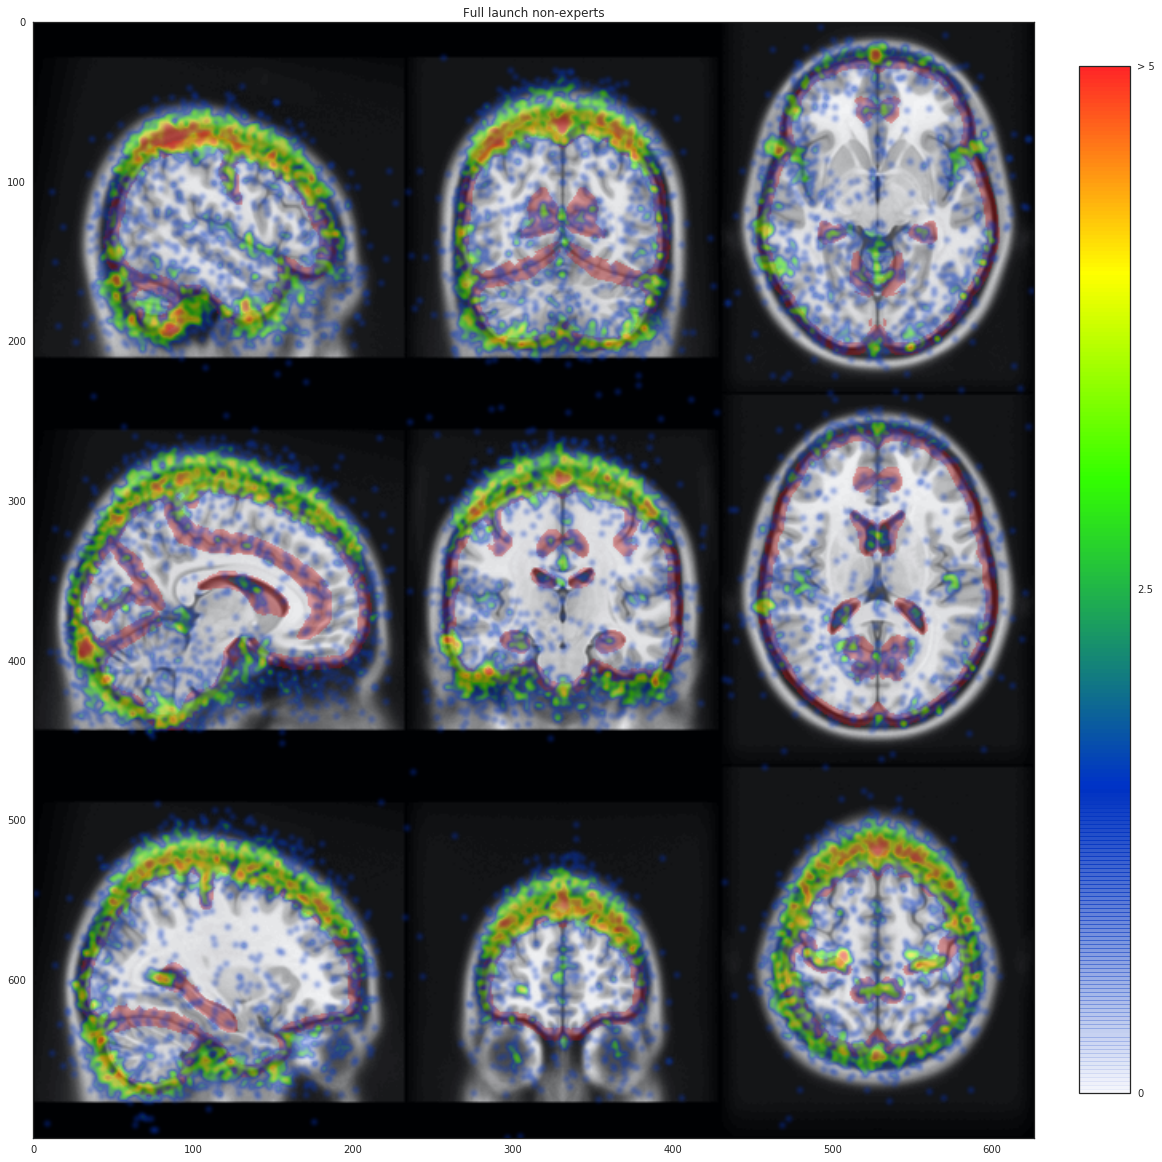

In [105]:
from heatmappy import Heatmapper
from PIL import Image
patches=list()
for ind, row in df_ids_imgnm.iterrows():
    out_tmp = out[out['ID'] == row.ID]
    patches.append([(row.x,row.y) for ind,row in out_tmp.iterrows()])
# plot heat map on the template
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(111)
img = Image.open(os.path.join(path_root,'tutorial_v2/anat_fail/anat_template_stereotaxic.png'))
ax.set_title('Full launch non-experts')
patches = [x for x in sum(patches,[]) if str(x[0]) != 'nan'] 
heatmapper = Heatmapper(opacity=0.5,
                        point_diameter=8,
                        point_strength = 0.2,
                        colours=a)
heatmap = heatmapper.heatmap_on_img(patches, img)
im = ax.imshow(heatmap,cmap=coll_r)
cbar = fig.colorbar(im, orientation='vertical', ticks=[0, 125, 255],fraction=0.046, pad=0.04)
cbar.ax.set_yticklabels(['0', '2.5', '> 5'])
img.close()
heatmap.close()

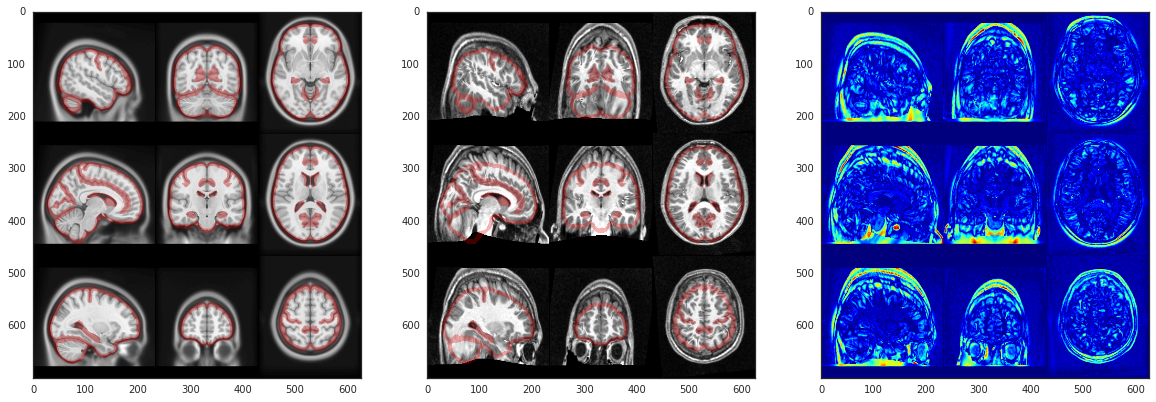

In [109]:
import pylab
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
img1 = mpimg.imread(os.path.join(path_root,'tutorial_v2/anat_fail/anat_template_stereotaxic.png'))
img2 = mpimg.imread(os.path.join(base_path_dest,'X_0021014_anat.png'))

# Calculate the absolute difference on each channel separately
error_r = np.fabs(np.subtract(img2[:,:,0], img1[:,:,0]))
error_g = np.fabs(np.subtract(img2[:,:,1], img1[:,:,1]))
error_b = np.fabs(np.subtract(img2[:,:,2], img1[:,:,2]))

# Calculate the maximum error for each pixel
lum_img = np.maximum(np.maximum(error_r, error_g), error_b)

# Uncomment the next line to turn the colors upside-down
#lum_img = np.negative(lum_img);

fig = plt.figure(figsize=(20,20))
ax1 = fig.add_subplot(131)
ax1.imshow(img1)
ax2 = fig.add_subplot(132)
ax2.imshow(img2)
ax3 = fig.add_subplot(133)
ax3.imshow(lum_img,cmap='jet')
# Choose a color palette
#ax3.set_cmap('Spectral') 
